In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='ticks', context='talk')
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point
import fiona
%matplotlib inline

This section joins the watershed shapefile with the 500k geologic map shapefile

In [34]:
#this section is pulled from the geopandas github https://github.com/geopandas/geopandas/issues/400 that speeds up overlay
#this version runs in <3% of the time of the original, which means minutes instead of days for this dataset.
import geopandas as gp

def spatial_overlays(df1, df2, how='intersection'):
    '''Compute overlay intersection of two 
        GeoPandasDataFrames df1 and df2
    '''
    df1 = df1.copy()
    df2 = df2.copy()
    df1['geometry'] = df1.geometry.buffer(0)
    df2['geometry'] = df2.geometry.buffer(0)
    if how=='intersection':
        # Spatial Index to create intersections
        spatial_index = df2.sindex
        df1['bbox'] = df1.geometry.apply(lambda x: x.bounds)
        df1['histreg']=df1.bbox.apply(lambda x:list(spatial_index.intersection(x)))
        pairs = df1['histreg'].to_dict()
        nei = []
        for i,j in pairs.items():
            for k in j:
                nei.append([i,k])
        
        pairs = gp.GeoDataFrame(nei, columns=['idx1','idx2'], crs=df1.crs)
        pairs = pairs.merge(df1, left_on='idx1', right_index=True)
        pairs = pairs.merge(df2, left_on='idx2', right_index=True, suffixes=['_1','_2'])
        pairs['Intersection'] = pairs.apply(lambda x: (x['geometry_1'].intersection(x['geometry_2'])).buffer(0), axis=1)
        pairs = gp.GeoDataFrame(pairs, columns=pairs.columns, crs=df1.crs)
        cols = pairs.columns.tolist()
        cols.remove('geometry_1')
        cols.remove('geometry_2')
        cols.remove('histreg')
        cols.remove('bbox')
        cols.remove('Intersection')
        dfinter = pairs[cols+['Intersection']].copy()
        dfinter.rename(columns={'Intersection':'geometry'}, inplace=True)
        dfinter = gp.GeoDataFrame(dfinter, columns=dfinter.columns, crs=pairs.crs)
        dfinter = dfinter.loc[dfinter.geometry.is_empty==False]
        return dfinter
    elif how=='difference':
        spatial_index = df2.sindex
        df1['bbox'] = df1.geometry.apply(lambda x: x.bounds)
        df1['histreg']=df1.bbox.apply(lambda x:list(spatial_index.intersection(x)))
        df1['new_g'] = df1.apply(lambda x: reduce(lambda x, y: x.difference(y).buffer(0), [x.geometry]+list(df2.iloc[x.histreg].geometry)) , axis=1)
        df1.geometry = df1.new_g
        df1 = df1.loc[df1.geometry.is_empty==False].copy()
        df1.drop(['bbox', 'histreg', new_g], axis=1, inplace=True)
        return df1

In [37]:
huc8=gpd.read_file(r'J:\Geology\WSGS\GIS\huc_12.shp')
huc8= huc8.to_crs({'init': 'epsg:3732'})
huc8['area']=huc8.area

In [38]:
bedrock=gpd.read_file(r'J:\Geology\WSGS\GIS\bedrock.shp')
bedrock= bedrock.to_crs({'init': 'epsg:3732'})

In [40]:
overlain=spatial_overlays(bedrock,huc8, how='intersection')
overlain['area'] = overlain.area
overlain.to_csv('J:/Geology/WSGS/intersection_huc12.csv')

In [41]:
overlain.columns

Index(['idx1', 'idx2', 'Symbol_Ori', 'Unit_Name', 'Unit_Descr', 'Unit_Age',
       'Symbol', 'RuleID_1', 'Shape_Leng_1', 'Shape_Area_1', 'AREA',
       'PERIMETER', 'WY_HU12_', 'WY_HU12_ID', 'HUC_8', 'HUC_10', 'HUC_12',
       'ACRES', 'STATES', 'NCONTRB_A', 'HU_10_DS', 'HU_10_NAME', 'HU_10_MOD',
       'HU_10_TYPE', 'HU_12_DS', 'HU_12_NAME', 'HU_12_MOD', 'HU_12_TYPE',
       'HU_2_NAME', 'HU_4_NAME', 'HU_6_NAME', 'HU_8_NAME', 'Shape_Leng_2',
       'Shape_Area_2', 'area', 'geometry'],
      dtype='object')

In [42]:
test1=overlain.groupby(['HU_12_NAME','Unit_Name']).sum()['area'].unstack(level=0)

In [43]:
basinNames=test1.columns

In [50]:
for i in range(len(basinNames)):
    test1[basinNames[i]+' percentage']=100*(test1[basinNames[i]]/huc8[huc8['HU_12_NAME']==basinNames[i]]['area'].values).values

In [51]:
test1.fillna(0).to_csv('J:/Geology/WSGS/basin_area_formation_huc12.csv')

This next section imports the NURE point data

In [52]:
df= pd.read_csv(r'M:/critical/imputed.csv')

In [53]:
from geopandas import GeoDataFrame
from shapely.geometry import Point
import fiona

geometry = [Point(xy) for xy in zip(df.longitude, df.latitude)]
crs = {'init': 'epsg:3732'} #http://www.spatialreference.org/ref/epsg/2263/
geo_df = GeoDataFrame(df, crs={'init': 'epsg:4326'}, geometry=geometry)

geo_df.to_file(driver='ESRI Shapefile', filename='data.shp')
projGeoDF=geo_df.to_crs(crs)

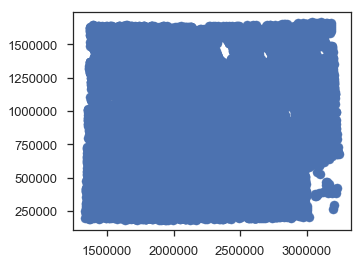

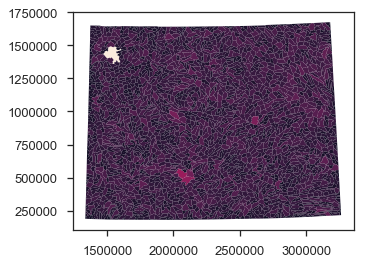

In [54]:
projGeoDF.plot()
huc8.plot(column='Shape_Area')

In [55]:
points_with_basin=gpd.sjoin(projGeoDF, huc8, how='inner', op='intersects')

In [56]:
points_with_basin.columns

Index(['Unnamed: 0', 'u_dn_ppm', 'u_fl_ppm', 'ag_ppm', 'al_pct', 'as_ppm',
       'au_ppm', 'b_ppm', 'ba_ppm', 'be_ppm', 'bi_ppm', 'ca_pct', 'cd_ppm',
       'ce_ppm', 'cl_ppm', 'co_ppm', 'cr_ppm', 'cs_ppm', 'cu_ppm', 'dy_ppm',
       'eu_ppm', 'fe_pct', 'hf_ppm', 'k_pct', 'la_ppm', 'li_ppm', 'lu_ppm',
       'mg_pct', 'mn_ppm', 'mo_ppm', 'na_pct', 'nb_ppm', 'ni_ppm', 'p_ppm',
       'pb_ppm', 'rb_ppm', 'sb_ppm', 'sc_ppm', 'se_ppm', 'sm_ppm', 'sn_ppm',
       'sr_ppm', 'ta_ppm', 'tb_ppm', 'th_ppm', 'ti_ppm', 'v_ppm', 'w_ppm',
       'y_ppm', 'yb_ppm', 'zn_ppm', 'zr_ppm', 'longitude', 'latitude',
       'geometry', 'index_right', 'AREA', 'PERIMETER', 'WY_HU12_',
       'WY_HU12_ID', 'HUC_8', 'HUC_10', 'HUC_12', 'ACRES', 'STATES',
       'NCONTRB_A', 'HU_10_DS', 'HU_10_NAME', 'HU_10_MOD', 'HU_10_TYPE',
       'HU_12_DS', 'HU_12_NAME', 'HU_12_MOD', 'HU_12_TYPE', 'HU_2_NAME',
       'HU_4_NAME', 'HU_6_NAME', 'HU_8_NAME', 'Shape_Leng', 'Shape_Area',
       'area'],
      dtype='object')

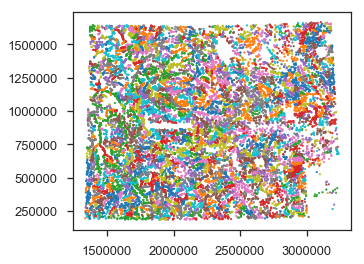

In [64]:
points_with_basin.plot('HU_12_NAME', s=3)

In [97]:
basinFormations=pd.read_csv('J:/Geology/WSGS/basin_area_formation_huc12_percentage.csv', index_col='Unit_Name')

In [98]:
rotated=basinFormations.transpose()
rotated['HU_12_NAME']=rotated.index

In [99]:
merged=points_with_basin.merge(rotated, on='HU_12_NAME')

In [101]:
merged.to_csv('J:/Geology/WSGS/hu_12_formations_points.csv')